In [1]:
import numpy as np
from random import gauss, seed
from matplotlib import pyplot as plt

In [2]:
seed(123)

In [3]:
nstep = 800

In [4]:
hidden = [[2,0]]
for _ in range(nstep-1):
    prev = hidden[-1]
    a = 0.994*prev[0] + 0.1*prev[1] + gauss(0,1)*0.01
    b = 0.994*prev[1] - 0.1*prev[0] + gauss(0,1)*0.01
    hidden.append([a,b])

In [5]:
observe = [x[0] + x[1]**2 + gauss(0,1)*15 for x in hidden]

In [6]:
hidden, observe = np.array(hidden), np.array(observe)

In [7]:
hidden.shape, observe.shape

((800, 2), (800,))

In [8]:
class ParticleFilter:
    def __init__ (self, nparticles, hidden_dim, evol_model, observe_model, resample_2entropy = 0.1):
        self.nparticles = nparticles
        self.hidden_dim = hidden_dim
        self.evol_model = evol_model
        self.observe_model = observe_model
        self.resample_2entropy = resample_2entropy
        self.resamples = 0
        self.step_calls = 0
        
        self.particles = np.random.normal(size=[nparticles, hidden_dim])# + np.array([2,0], 'float64')
        self.logweights = np.zeros([nparticles], dtype='float64')
        
    def step(self, observe):
        self.step_calls += 1
        
        new_logweights = self.observe_model(self.particles, observe)
        self.logweights += new_logweights
        self.logweights -= self.logweights.mean()
        self.logweights = np.clip(self.logweights, -20, 20)
        
        #resample if entropy is too low:
        weights = np.exp(self.logweights)
        weights /= weights.sum()

        ent = np.sum(-weights*np.log2(weights))
        tent = 2**ent

        if tent/self.nparticles < self.resample_2entropy:
            self.resample()
        
        self.particles = self.evol_model(self.particles)
        
        weights = np.exp(self.logweights)
        weights /= weights.sum()
        return self.particles, weights
    
    def filtrate(self, observations):
        ps = []
        
        for obs in observations:
            p, w = self.step(obs)
            ix = np.random.choice(np.arange(len(p)), size=len(p), p=w)
            p = p[ix]
            ps.append(p)
        ps = np.array(ps)
        print(self.resamples/self.step_calls)
        return ps
    
    def resample(self):
        self.resamples += 1
        weights = np.exp(self.logweights)
        #print(weights.sum())
        weights /= weights.sum()
        ix = np.random.choice(np.arange(self.nparticles), size=self.nparticles, p=weights)
        self.particles = self.particles[ix]
        self.logweights = np.zeros_like(self.logweights)

In [9]:
def observation(particles, observe):
    x = particles
    return -(x[:,0] + x[:,1]**2 - observe)**2/(2*15**2)

def evolution(particles):
    x = particles
    return np.array([0.994*x[:,0] + 0.1*x[:,1],
                     0.994*x[:,1] - 0.1*x[:,0]]).T + np.random.normal(scale=0.01, size=x.shape)

In [19]:
pf = ParticleFilter(200, 2, evolution, observation, resample_2entropy=0.5)

In [20]:
ps = pf.filtrate(observe)

0.00125


In [21]:
pf.resamples

1

In [22]:
pm = np.mean(ps, axis=1)

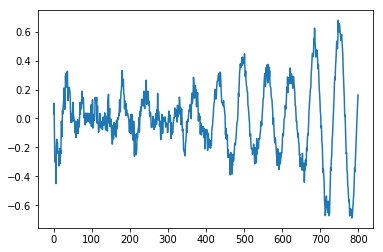

In [23]:
plt.plot(np.arange(len(pm)), pm[:,0])
plt.show()

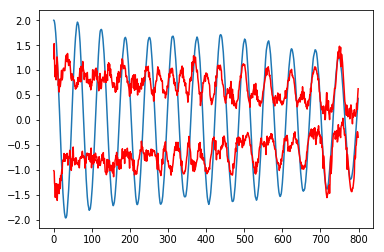

In [24]:
plt.plot(np.arange(len(hidden)), hidden[:,0])
plt.plot(np.arange(len(hidden)), np.percentile(ps, 90, axis=1)[:,0], c='r')
plt.plot(np.arange(len(hidden)), np.percentile(ps, 10, axis=1)[:,0], c='r')
plt.show()

In [25]:
points = []
for x in range(ps.shape[0]):
    for y in range(ps.shape[1]):
        points.append([x, ps[x,y,0]])
points = np.array(points)
#points = np.reshape(points, ps[:,:,0].shape)
hist, _, _ = np.histogram2d(points[:,0], points[:,1], bins=40)

In [26]:
points.shape

(160000, 2)

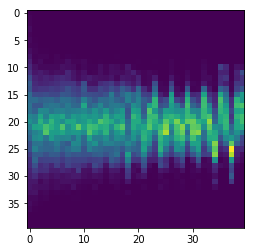

In [27]:
plt.imshow(hist.T)
plt.show()

In [19]:
from scipy.misc import imsave

In [20]:
imsave('img.png', hist.T)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.
